In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import pandas as pd

import numpy as np
import torch

In [4]:
# set up logging
import logging

logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
    force=True,
)

### Configs

In [5]:
import args as args_loading

# used when run from command line
args = args_loading.parse_args()
# print(f"Parsing args = {args}")

In [6]:

run_name = args.get("run_name", "house_electric_fit_hypernet_prior")

activation = args.get("activation", "conditionalfourier2")  # conditionalnn
bnn_width = args.get("bnn_width", 128)

n_iterations = args.get("n_iterations", 2001)

num_function_samples = args.get("num_function_samples", 1024)
batch_size = args.get("batch_size", 128)
shuffle_xs_n_times = args.get("shuffle_xs_n_times", 8)

report_every_n_iterations = args.get("report_every_n_iterations", 250)
random_seed = args.get("random_seed", 1610)

In [8]:
print(f"Configuration = {locals()}")

Configuration = {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "get_ipython().run_line_magic('reload_ext', 'autoreload')\nget_ipython().run_line_magic('autoreload', '2')", 'import sys\nsys.path.append("..")', 'import pandas as pd\n\nimport numpy as np\nimport torch', '# set up logging\nimport logging\n\nlogging.basicConfig(\n    level=logging.INFO,\n    stream=sys.stdout,\n    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",\n    force=True,\n)', 'import args as args_loading\n\n# used when run from command line\nargs = args_loading.parse_args()\n# print(f"Parsing args = {args}")', 'run_name = args.get("run_name", "house_electric_fit_hypernet_prior")\n\nactivation = args.get("activation", "conditionalfourier2")  # conditionalnn\nbnn_width 

### Data

In [9]:
import grids

from data.uci_household_power_consumption import load as data_src

In [10]:
datafile = "../data/uci_household_power_consumption/individual+household+electric+power+consumption.npy"

In [11]:
(
    x_train,
    y_train,
    x_test,
    y_test,
    y_train_r_mean,
    y_train_r_std,
    tt_split_hsh,
) = data_src.prepare_data(datafile=datafile)
print("data", x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train_r_mean, y_train_r_std, tt_split_hsh)

data torch.Size([1366186, 8]) torch.Size([1366186]) torch.Size([683094, 8]) torch.Size([683094]) tensor(9.3178) tensor(9.5873) 9d025f6b9a0637a8e6858f9ad33f3a12


In [12]:
x_min, x_max = grids.get_input_range(x_train.numpy(), x_test.numpy())
rand_generator = grids.MeasureSetGenerator(x_train.numpy(), x_min, x_max, 0.7)


def create_training_grid(n_nodes, lengthscale=None):
    if lengthscale and create_training_grid.warning_counter < 10:
        logging.warning(f"[create_training_grid] lengthscale={lengthscale} is ignored. Input grid is based on data. @TODO implement range scaling?")
        create_training_grid.warning_counter += 1
    return rand_generator.get(n_nodes)


create_training_grid.warning_counter = 0

In [13]:
logging.info(f"x_min={x_min}, x_max={x_max}")

[2025-01-27 10:13:41,054] {/tmp/ipykernel_2478985/3110725809.py:1} INFO - x_min=[-1.0972173  -5.447677   -0.9972217  -0.18226153 -0.22281936 -0.76589495
 -1.7212899  -1.7317975 ], x_max=[11.236936   4.111009   9.858398  14.1361475 13.545257   2.908641
  1.7442578  1.7294537]


In [14]:
final_evaluation_input_grid = create_training_grid(num_function_samples)

logging.info(f"final_evaluation_input_grid={final_evaluation_input_grid.shape}")

[2025-01-27 10:13:41,138] {/tmp/ipykernel_2478985/559875539.py:3} INFO - final_evaluation_input_grid=torch.Size([256, 8])


### Training prior

In [15]:
import train_hypernet_priors_and_activations as train
import import_export

ERROR: Failed to import from rational.torch: No module named 'rational'
[2025-01-27 10:13:41,652] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../utils.py:22} WARNING - WARNING: rational-activations are not installed (No module named 'rational')!


In [16]:
import conditioning_on_varying_lengthscale

In [17]:
# Hypernet takes 1D lengthscales generaterd by target_hyperparams_generator


def create_target_generator(lengthscale, outputscale=1.0, nu=3 / 2):
    return conditioning_on_varying_lengthscale.create_generator_matern_gp(
        lengthscale=lengthscale, outputscale=outputscale, nu=nu
    )


target_hyperparams_generator = (
    conditioning_on_varying_lengthscale.yield_conditioning_matern_gp_lengthscale(
        ls=[
            10.0,
            5.0,
            0.5,
            0.25,
            0.75,
            0.05,
            2.5,
            0.1,
            7.5,
            0.075,
            1.0,
            0.075,
            2.5,
            0.25,
            7.5,
            4.0,
        ]
    )
)

evaluation = conditioning_on_varying_lengthscale.evaluation_matern_gp

condition_dimensionality = 1
hypernet_input_builder = (
    lambda train_grid_x, batch_target, generator_hyperparams: torch.tensor(
        generator_hyperparams["lengthscale"]
    )
)

In [18]:
fit = train.run_main(
    create_training_grid=create_training_grid,
    create_target_generator=create_target_generator,
    target_hyperparams_generator=target_hyperparams_generator,
    hypernet_input_builder=hypernet_input_builder,
    condition_dimensionality=condition_dimensionality,
    evaluation=evaluation,
    final_evaluation_input_grid=final_evaluation_input_grid,
    ##############################    
    run_name=run_name,
    ##############################
    activation=activation,
    bnn_width=bnn_width,
    loss_func="wasserstein_distance",
    n_iterations=n_iterations,
    lr=0.01,
    report_every_n_iterations=report_every_n_iterations,
    batch_size=batch_size,
    num_function_samples=num_function_samples,
    shuffle_xs_n_times=shuffle_xs_n_times,
    freeze_training_grid=False,
    ##############################
    # Data:
    final_evaluation_batch_size=1024,
    ##############################
    random_seed=random_seed,
    ##############################
    hypernet_arch_no=0,
    zero_locations=True,  # for priors: do we want to learn locations or only stds    
)

print("Storing fit into {run_name}_results.json")
import_export.save_to_json(run_name+"_results.json", fit)

[2025-01-27 10:13:42,379] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../train_hypernet_priors_and_activations.py:196} INFO - Configuration: {'create_training_grid': <function create_training_grid at 0x7da1246e8ca0>, 'create_target_generator': <function create_target_generator at 0x7da0a1cd1d30>, 'target_hyperparams_generator': <generator object yield_conditioning_matern_gp_lengthscale at 0x7da031d9c6d0>, 'hypernet_input_builder': <function <lambda> at 0x7da031daf0d0>, 'condition_dimensionality': 1, 'evaluation': <function evaluation_matern_gp at 0x7da031d943a0>, 'run_name': 'house_electric_fit_hypernet_prior', 'bnn_width': 128, 'loss_func': <function wasserstein_distance at 0x7da03214c040>, 'batch_size': 128, 'num_function_samples': 256, 'shuffle_xs_n_times': 2, 'freeze_training_grid': False, 'final_evaluation_input_grid': tensor([[-0.1921, -0.1232, -0.7270,  ..., -0.6474,  0.3296,  1.6405],
        [-1.0972,  0.2412, -0.9071,  ..., -0.7659,  1.2410, -1.6308],
        [ 0.6065, -0.259

  0%|          | 0/4 [00:00<?, ?it/s]

[2025-01-27 10:14:00,169] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=0.025 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:00,905] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=10.0 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:10,408] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../train_hypernet_priors_and_activations.py:121} INFO - [it=0] loss= 92.122 wasserstein=95.381  [target vs learning]: mean = -0.01+/-0.74 vs -0.23+/-1.57,  std = 0.61+/-0.17 vs 9.93+/-0.92,  skewness = 0.12+/-0.91 vs 0.01+/-0.17,  kurtosis = 1.34+/-1.20 vs -0.01+/-0.27
[2025-01-27 10:14:10,494] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../utils_plotting.py:155} WARNING - [utils_plotting] Slicing window width for dim=0 increased from 0.5 to 8.0 to capture 184 pts.
[2025-01-27 10:14:10,498] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../utils_pl

 25%|██▌       | 1/4 [00:11<00:35, 11.94s/it]

[2025-01-27 10:14:12,107] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=5.0 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:12,517] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=0.5 is ignored. Input grid is based on data. @TODO implement range scaling?


 50%|█████     | 2/4 [00:14<00:12,  6.42s/it]

[2025-01-27 10:14:14,675] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=0.25 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:15,114] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=0.75 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:16,928] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../train_hypernet_priors_and_activations.py:121} INFO - [it=2] loss= 20.873 wasserstein=19.882  [target vs learning]: mean = -0.01+/-0.14 vs -0.03+/-1.05,  std = 0.99+/-0.06 vs 4.82+/-0.39,  skewness = -0.01+/-0.15 vs -0.00+/-0.42,  kurtosis = -0.02+/-0.28 vs 0.82+/-0.59
[2025-01-27 10:14:17,001] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../utils_plotting.py:155} WARNING - [utils_plotting] Slicing window width for dim=0 increased from 0.5 to 8.0 to capture 185 pts.
[2025-01-27 10:14:17,004] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../utils_p

 75%|███████▌  | 3/4 [00:18<00:05,  5.32s/it]

[2025-01-27 10:14:18,688] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=0.05 is ignored. Input grid is based on data. @TODO implement range scaling?
[2025-01-27 10:14:19,115] {/tmp/ipykernel_2478985/2656666378.py:7} WARNING - [create_training_grid] lengthscale=2.5 is ignored. Input grid is based on data. @TODO implement range scaling?


100%|██████████| 4/4 [00:20<00:00,  5.18s/it]

training history:
   iteration       loss  lengthscale  wasserstein_distance  \
0          0  92.121994        10.00             95.380592   
1          1  27.900103         0.50                   NaN   
2          2  20.873037         0.75             19.881872   
3          3  14.258093         2.50                   NaN   

   learning_mean_mean  learning_mean_std  learning_std_mean  learning_std_std  \
0           -0.232945           1.568098           9.934839          0.918471   
1                 NaN                NaN                NaN               NaN   
2           -0.025096           1.050106           4.817077          0.388440   
3                 NaN                NaN                NaN               NaN   

   learning_skewness_mean  learning_skewness_std  learning_kurtosis_mean  \
0                0.005549               0.166290               -0.012633   
1                     NaN                    NaN                     NaN   
2               -0.003547            

[2025-01-27 10:14:23,918] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../conditioning_on_varying_lengthscale.py:90} INFO - final evaluation loss for {'lengthscale': 0.01}: 5.805347919464111
[2025-01-27 10:14:23,920] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../conditioning_on_varying_lengthscale.py:71} INFO - final evaluation for target_hyperparams={'lengthscale': 0.1}
[2025-01-27 10:14:26,886] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../conditioning_on_varying_lengthscale.py:90} INFO - final evaluation loss for {'lengthscale': 0.1}: 6.090122222900391
[2025-01-27 10:14:26,887] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../conditioning_on_varying_lengthscale.py:71} INFO - final evaluation for target_hyperparams={'lengthscale': 1.0}
[2025-01-27 10:14:29,826] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../conditioning_on_varying_lengthscale.py:90} INFO - final evaluation loss for {'lengthscale': 1.0}: 4.639021873474121
[2025-01-27 10:14:29,827] {/home/kusmierc/bnn-from-gp/bnngp/note

{'prior_type': 'hypernet',
 'net_width': 128,
 'hypernet_input_builder': <function __main__.<lambda>(train_grid_x, batch_target, generator_hyperparams)>,
 'condition_dimensionality': 1,
 'target_hyperparams_generator': <generator object yield_conditioning_matern_gp_lengthscale at 0x7da031d9c6d0>,
 'create_target_generator': {'name': '<function create_target_generator at 0x7da0a1cd1d30>',
  'type': 'pickle',
  'pickle': 'gASVKAAAAAAAAACMCF9fbWFpbl9flIwXY3JlYXRlX3RhcmdldF9nZW5lcmF0b3KUk5Qu'},
 'evaluation_func': {'name': '<function evaluation_matern_gp at 0x7da031d943a0>',
  'type': 'pickle',
  'pickle': 'gASVQAAAAAAAAACMI2NvbmRpdGlvbmluZ19vbl92YXJ5aW5nX2xlbmd0aHNjYWxllIwUZXZhbHVhdGlvbl9tYXRlcm5fZ3CUk5Qu'},
 'initial_performance': [[{'lengthscale': 0.01}, 81.3429183959961],
  [{'lengthscale': 0.1}, 81.9656753540039],
  [{'lengthscale': 1.0}, 84.45628356933594],
  [{'lengthscale': 10.0}, 94.10199737548828]],
 'evaluation': [[{'lengthscale': 0.01}, 5.805347919464111],
  [{'lengthscale': 0.

<Figure size 2560x1280 with 0 Axes>

<Figure size 2560x1280 with 0 Axes>

<Figure size 2560x1280 with 0 Axes>

<Figure size 2560x1280 with 0 Axes>

### Training prior results

In [19]:
print(pd.DataFrame({"final": fit["evaluation"], "initial": fit["initial_performance"]}).round(2))

final  \
0  ({'lengthscale': 0.01}, 5.805347919464111)   
1   ({'lengthscale': 0.1}, 6.090122222900391)   
2   ({'lengthscale': 1.0}, 4.639021873474121)   
3  ({'lengthscale': 10.0}, 7.055017471313477)   

                                      initial  
0   ({'lengthscale': 0.01}, 81.3429183959961)  
1    ({'lengthscale': 0.1}, 81.9656753540039)  
2   ({'lengthscale': 1.0}, 84.45628356933594)  
3  ({'lengthscale': 10.0}, 94.10199737548828)

In [20]:
history = pd.DataFrame(fit["history"])
print(history)

iteration       loss  lengthscale  wasserstein_distance  \
0          0  92.121994        10.00             95.380592   
1          1  27.900103         0.50                   NaN   
2          2  20.873037         0.75             19.881872   
3          3  14.258093         2.50                   NaN   

   learning_mean_mean  learning_mean_std  learning_std_mean  learning_std_std  \
0           -0.232945           1.568098           9.934839          0.918471   
1                 NaN                NaN                NaN               NaN   
2           -0.025096           1.050106           4.817077          0.388440   
3                 NaN                NaN                NaN               NaN   

   learning_skewness_mean  learning_skewness_std  learning_kurtosis_mean  \
0                0.005549               0.166290               -0.012633   
1                     NaN                    NaN                     NaN   
2               -0.003547               0.416918                0.817863   
3                     NaN                    NaN                     NaN   

   learning_kurtosis_std  target_mean_mean  target_mean_std  target_std_mean  \
0               0.265073         -0.009784         0.736742         0.610076   
1                    NaN               NaN              NaN              NaN   
2               0.590929         -0.010230         0.135295         0.993588   
3                    NaN               NaN              NaN              NaN   

   target_std_std  target_skewness_mean  target_skewness_std  \
0        0.168219              0.117743             0.911629   
1             NaN                   NaN                  NaN   
2        0.057849             -0.012425             0.154569   
3             NaN                   NaN                  NaN   

   target_kurtosis_mean  target_kurtosis_std  
0              1.335399             1.196682  
1                   NaN                  NaN  
2             -0.017472             0.280523  
3                   NaN                  NaN

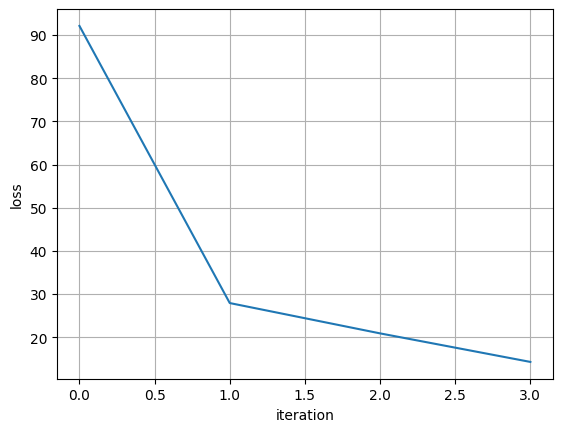

In [21]:
from matplotlib import pyplot as plt

plt.plot(history["iteration"], history["loss"])
plt.xlabel("iteration")
plt.ylabel("loss");
# plt.legend()
plt.grid(True)
plt.show()